In [1]:
from collections import defaultdict
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud
import pickle

pd.set_option('mode.chained_assignment', None)
all_df = pd.read_csv('debate_transcripts_v3_2020-02-26.csv', index_col = 0, encoding='latin1')
candidates = ['Bernie Sanders', 'Andrew Yang', 'Joe Biden', 'Amy Klobuchar', 
              'Pete Buttigieg', 'Elizabeth Warren', 'Tom Steyer', 'Michael Bloomberg']

all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 02-25-2020 to 06-26-2019
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   debate_name            5911 non-null   object 
 1   debate_section         5911 non-null   object 
 2   speaker                5911 non-null   object 
 3   speech                 5911 non-null   object 
 4   speaking_time_seconds  5395 non-null   float64
dtypes: float64(1), object(4)
memory usage: 277.1+ KB


In [2]:
data = pd.read_pickle('data_lemma_dtm.pkl')
data = data.transpose()
data

speaker,Bernie Sanders,Andrew Yang,Joe Biden,Amy Klobuchar,Pete Buttigieg,Elizabeth Warren,Tom Steyer,Michael Bloomberg
aa,0,0,0,1,0,0,0,0
aapi,0,0,0,0,0,0,1,0
abandon,0,0,0,0,1,0,1,0
abate,0,0,1,0,0,0,0,0
abc,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
zealand,0,0,0,0,1,0,0,0
zero,3,11,3,0,5,7,0,1
zip,1,1,1,0,0,0,0,0
zone,0,0,3,0,2,0,0,0


In [3]:
def top_words(data, number):
    top_words = {}
    for speaker in data.columns:
        top = data[speaker].sort_values(ascending=False).head(number)
        top_words[speaker] = list(zip(top.index, top.values))
    return top_words

In [4]:
top_dict = top_words(data, 50)
top_df = pd.DataFrame.from_dict(top_dict)
top_df.head()

,Bernie Sanders,Andrew Yang,Joe Biden,Amy Klobuchar,Pete Buttigieg,Elizabeth Warren,Tom Steyer,Michael Bloomberg
0,"(people, 253)","(american, 71)","(make, 195)","(think, 182)","(president, 141)","(people, 222)","(people, 95)","(just, 34)"
1,"(country, 154)","(people, 53)","(say, 191)","(people, 166)","(make, 114)","(need, 170)","(american, 76)","(people, 31)"
2,"(american, 109)","(country, 53)","(fact, 189)","(say, 154)","(people, 113)","(make, 154)","(say, 57)","(city, 30)"
3,"(say, 101)","(say, 45)","(people, 154)","(make, 138)","(american, 112)","(want, 132)","(thats, 52)","(think, 28)"
4,"(year, 100)","(know, 39)","(thats, 145)","(president, 122)","(just, 109)","(work, 125)","(im, 49)","(new, 27)"


In [5]:
def find_common(data, top_dict):
    words = []
    for speaker in data.columns:
        top = [word for (word, count) in top_dict[speaker]]
        for t in top:
            words.append(t)
    Counter(words).most_common()
    add_stop_words = [word for word, count in Counter(words).most_common() if count > 3]
    return add_stop_words

In [6]:
def create_dtm(data_lemma, stop_words):
    cv = CountVectorizer(stop_words=stop_words)
    data_cv = cv.fit_transform(data_lemma.speech)
    dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    dtm.index = data_lemma.index
    dtm = dtm.transpose()
    pickle.dump(cv, open("cv.pkl", "wb"))
    return dtm

In [7]:
def remove_common(data_lemma, add_stop_words):
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
    add_stop_words = ['ive', 'iam', 'youre', 'youve', 'weve', 'hes', 'shes', 'its', 'theyre', 'theyve']
    stop_words = stop_words.union(add_stop_words)
    dtm_unique = create_dtm(data_lemma, stop_words)
    return dtm_unique, stop_words

In [8]:
data_lemma = pd.read_pickle("corpus_lemma.pkl")
data_lemma = data_lemma.set_index("speaker")
add_stop_words = find_common(data, top_dict)
remove_common_tuple = remove_common(data_lemma, add_stop_words)
dtm_unique = remove_common_tuple[0]
stop_words = remove_common_tuple[1]
dtm_unique.to_pickle('dtm_unique.pkl')
pickle.dump(stop_words, open("stop_words.pkl", "wb"))

In [9]:
top_dict_unique = top_words(dtm_unique, 50)
top_df_unique = pd.DataFrame.from_dict(top_dict_unique)
top_df_unique.head()

,Bernie Sanders,Andrew Yang,Joe Biden,Amy Klobuchar,Pete Buttigieg,Elizabeth Warren,Tom Steyer,Michael Bloomberg
0,"(healthcare, 91)","(job, 34)","(fact, 189)","(bring, 68)","(community, 47)","(fight, 81)","(stage, 34)","(city, 30)"
1,"(million, 73)","(problem, 28)","(number, 90)","(win, 62)","(happen, 46)","(family, 70)","(climate, 33)","(new, 27)"
2,"(tell, 60)","(donald, 28)","(able, 88)","(donald, 49)","(washington, 45)","(help, 55)","(corporation, 32)","(york, 23)"
3,"(company, 54)","(family, 25)","(sure, 84)","(vote, 47)","(sure, 40)","(healthcare, 54)","(beat, 31)","(problem, 12)"
4,"(industry, 52)","(economy, 23)","(deal, 82)","(lead, 40)","(war, 37)","(build, 54)","(government, 30)","(lot, 11)"


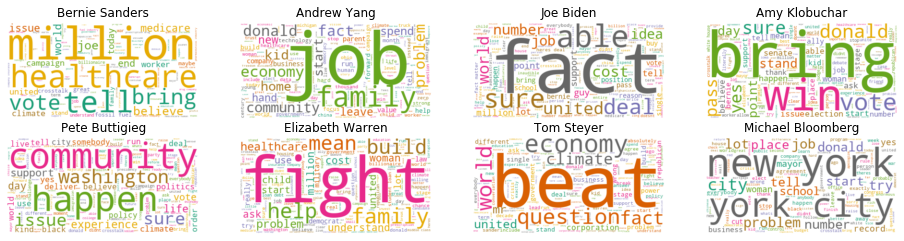

In [10]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [16, 6]

full_names = ['Bernie Sanders', 'Andrew Yang', 'Joe Biden', 
              'Amy Klobuchar', 'Pete Buttigieg', 'Elizabeth Warren', 'Tom Steyer', 'Michael Bloomberg']

# Create subplots for each comedian
for index, comedian in enumerate(data.columns):
    wc.generate(data_lemma.speech[comedian])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

In [11]:
vocabulary = pd.read_pickle('vocabulary.pkl')
vocabulary = vocabulary.sort_values(by='vocabulary', ascending=False)

In [12]:
vocabulary

,speaker,vocabulary
4,Pete Buttigieg,2991
2,Joe Biden,2755
3,Amy Klobuchar,2564
5,Elizabeth Warren,2469
0,Bernie Sanders,2305
1,Andrew Yang,1764
6,Tom Steyer,1474
7,Michael Bloomberg,1009


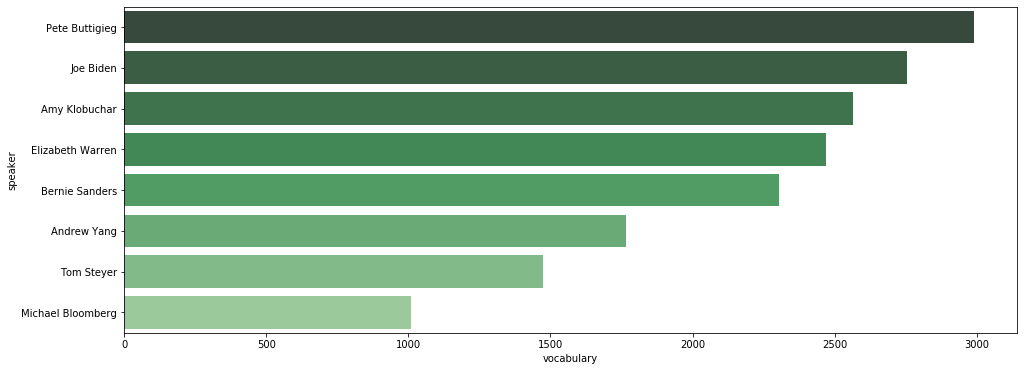

In [13]:
sns.barplot(x="vocabulary", y="speaker", data=vocabulary, palette="Greens_d")